In [1]:
#Imports

import cv2
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [10]:
#Capture and Save Images Function

def capture_and_save_image(person_id, person_name, dataset_path):
    video = cv2.VideoCapture(0)
    facedetect = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    faces_data = []
    i = 0

    id_name = f"{person_id}-{person_name}"
    person_folder = os.path.join(dataset_path, id_name)
    os.makedirs(person_folder, exist_ok=True)

    while True:
        ret, frame = video.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = facedetect.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            crop_img = frame[y:y + h, x:x + w]
            resized_img = cv2.resize(crop_img, (128, 128))
            if len(faces_data) < 100 and i % 10 == 0:
                faces_data.append(resized_img)
                img_path = os.path.join(person_folder, f'{id_name}_{len(faces_data)}.jpg')
                cv2.imwrite(img_path, resized_img)
            i += 1
            cv2.putText(frame, str(len(faces_data)), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (50, 50, 255), 1)

        cv2.imshow("Capture Images - Press 'c' to Capture, 'q' to Quit", frame)

        k = cv2.waitKey(1)
        if k == ord('q') or len(faces_data) == 100:
            break

    video.release()
    cv2.destroyAllWindows()

    faces_data = np.asarray(faces_data)
    return faces_data


In [3]:
#Load and Preprocess Images Function

def load_images(dataset_path, img_size=(128, 128)):
    faces_data = []
    labels = []
    label_map = {}
    current_label = 0

    for person_name in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person_name)
        if os.path.isdir(person_folder):
            label_map[current_label] = person_name
            for img_name in os.listdir(person_folder):
                img_path = os.path.join(person_folder, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    resized_img = cv2.resize(img, img_size)
                    faces_data.append(resized_img)
                    labels.append(current_label)
            current_label += 1

    faces_data = np.array(faces_data, dtype=np.float32)
    labels = np.array(labels)
    faces_data = faces_data / 255.0
    faces_data = np.expand_dims(faces_data, axis=-1)

    return faces_data, labels, label_map


In [4]:
#Train CNN Model Function

def train_cnn_model(dataset_path):
    faces_data, labels, label_map = load_images(dataset_path)

    num_classes = len(label_map)
    labels = to_categorical(labels, num_classes=num_classes)

    X_train, X_test, y_train, y_test = train_test_split(faces_data, labels, test_size=0.2, random_state=42)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    plot_training_history(history)
    evaluate_model(model, X_test, y_test, label_map)

    return model, label_map


In [5]:
#Plot Training History Function

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='purple')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='purple')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()


In [6]:
#Evaluate Model Function

def evaluate_model(model, X_test, y_test, label_map):
    y_pred = model.predict(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
    precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
    class_report = classification_report(y_test_labels, y_pred_labels, target_names=list(label_map.values()))

    print(f"\n{'='*40}\nEvaluation Metrics:\n{'='*40}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n", class_report)


In [7]:
#Main Function

def main():
    dataset_path = r'C:\Users\Sneha\Desktop\FACE RECOGNITION SYSTEM\data'
    existing_data_choice = input("Do you want to use existing data (y/n)? ")

    if existing_data_choice.lower() == 'n':
        person_id = input("Enter the new person's ID: ")
        person_name = input("Enter the new person's Name: ")
        faces_data = capture_and_save_image(person_id, person_name, dataset_path)
    else:
        append_choice = input("Do you want to append images to an existing person (y/n)? ")
        if append_choice.lower() == 'y':
            person_id = input("Enter the person's ID to append images: ")
            person_name = input("Enter the person's Name to append images: ")
            faces_data = capture_and_save_image(person_id, person_name, dataset_path)

    model, label_map = train_cnn_model(dataset_path)

    model_path = 'models/cnn_face_recognizer_best_model.h5'
    model.save(model_path)

    label_encoder_path = 'models/label_encoder.pkl'
    with open(label_encoder_path, 'wb') as f:
        pickle.dump(label_map, f)

    label_map_path = 'models/label_map.pkl'
    with open(label_map_path, 'wb') as f:
        pickle.dump(label_map, f)


Epoch 1/50


c:\Users\Sneha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.2763 - loss: 1.9047 - val_accuracy: 0.6873 - val_loss: 0.8638
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.7164 - loss: 0.7832 - val_accuracy: 0.8301 - val_loss: 0.5560
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.8502 - loss: 0.4485 - val_accuracy: 0.8687 - val_loss: 0.3601
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.8976 - loss: 0.2841 - val_accuracy: 0.8958 - val_loss: 0.3682
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9416 - loss: 0.1716 - val_accuracy: 0.9228 - val_loss: 0.2305
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.9664 - loss: 0.1283 - val_accuracy: 0.9305 - val_loss: 0.2349
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.9668 - loss: 0.1018 - val_accuracy: 0.9189 - val_loss: 0.2423
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.9829 - loss: 0.0658 - val_accuracy: 0.9266 - 

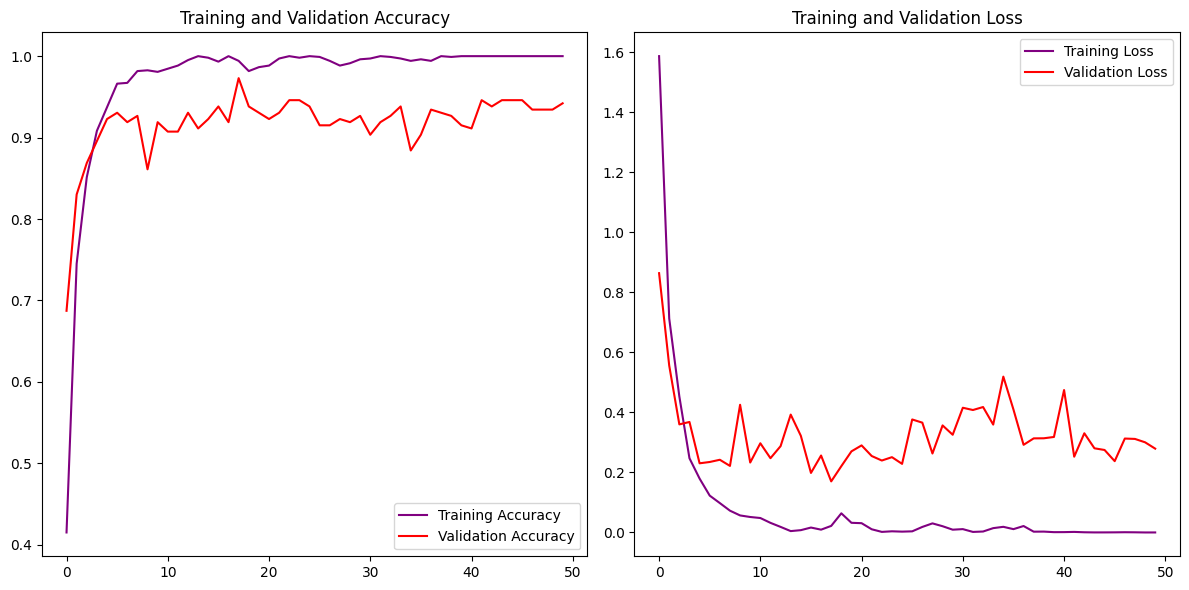

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step



Evaluation Metrics:
Accuracy: 0.9421
F1 Score: 0.9423
Precision: 0.9440
Recall: 0.9421

Classification Report:
                       precision    recall  f1-score   support

   101-Aishwarya_Rai       0.97      0.89      0.93        38
  102-Angelina_Jolie       0.93      0.98      0.95        43
           103-Dhoni       0.87      0.93      0.90        29
         104-Manjula       1.00      1.00      1.00        18
105-Sachin_Tendulkar       0.87      0.91      0.89        44
       106-Saravanan       1.00      1.00      1.00        20
           107-Sneha       1.00      1.00      1.00        24
     108-Virat_Kohli       0.97      0.91      0.94        43

            accuracy                           0.94       259
           macro avg       0.95      0.95      0.95       259
        weighted avg       0.94      0.94      0.94       259



In [9]:
#Execute Main Function

if __name__ == "__main__":
    main()
